In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import joblib
import shap
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
# set_config(transform_output="pandas")
import matplotlib
# feature importance
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

In [4]:
df=pd.read_parquet("../data/processed/ola_driver_merged.parquet")
df.head().T

,0,1,2,3,4
Driver_ID,1,2,4,5,6
Date_Of_Joining,2018-12-24,2020-06-11,2019-07-12,2019-09-01,2020-07-31
Total_Business_Value,1715580,0,350000,120360,1265000
Total_Had_Negative_Business,1,0,1,1,1
Has_Income_Increased,0,0,0,0,0
Has_Rating_Increased,0,0,0,0,1
Avg_Business_Value,571860,0,70000,40120,253000
Last_Reporting_Month,2019-03-01,2020-12-01,2020-04-01,2019-03-01,2020-12-01
Age,28,31,43,29,31
Gender,0,0,0,0,1


In [5]:
feature_columns = [
    'Total_Business_Value',
    'Total_Had_Negative_Business',
    'Has_Income_Increased',
    'Has_Rating_Increased',
    'Avg_Business_Value',
    'Age',
    'Gender',
    'Income',
    'Total_Income',
    'Education_Level',
    'City',
    'Joining_Designation',
    'Grade',
    'Quarterly_Rating',
    'Tenure',
    # 'Date_Of_Joining_month',
    # 'Date_Of_Joining_year',
    'Is_Valuable_Driver'
]

In [6]:
df["Churned"].value_counts(normalize=True)

Churned
1    0.678706
0    0.321294
Name: proportion, dtype: float64

In [7]:
class_weight = {
    0: 0.6,
    1: 0.3
}

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['City']),
    ],
     remainder='passthrough',
     verbose_feature_names_out=False
)

In [9]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        bagging_fraction=0.7612915269858092,
        learning_rate=0.19183342083552588,
        num_iterations=114,
        class_weight=class_weight
    ))
])

In [10]:
X = df[feature_columns]
y = df["Churned"]

In [11]:
pipeline_model = pipeline.fit(X, y);

[LightGBM] [Warning] bagging_fraction is set=0.7612915269858092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612915269858092
[LightGBM] [Warning] bagging_fraction is set=0.7612915269858092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612915269858092
[LightGBM] [Info] Number of positive: 1616, number of negative: 765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1420
[LightGBM] [Info] Number of data points in the train set: 2381, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513668 -> initscore=0.054686
[LightGBM] [Info] Start training from score 0.054686


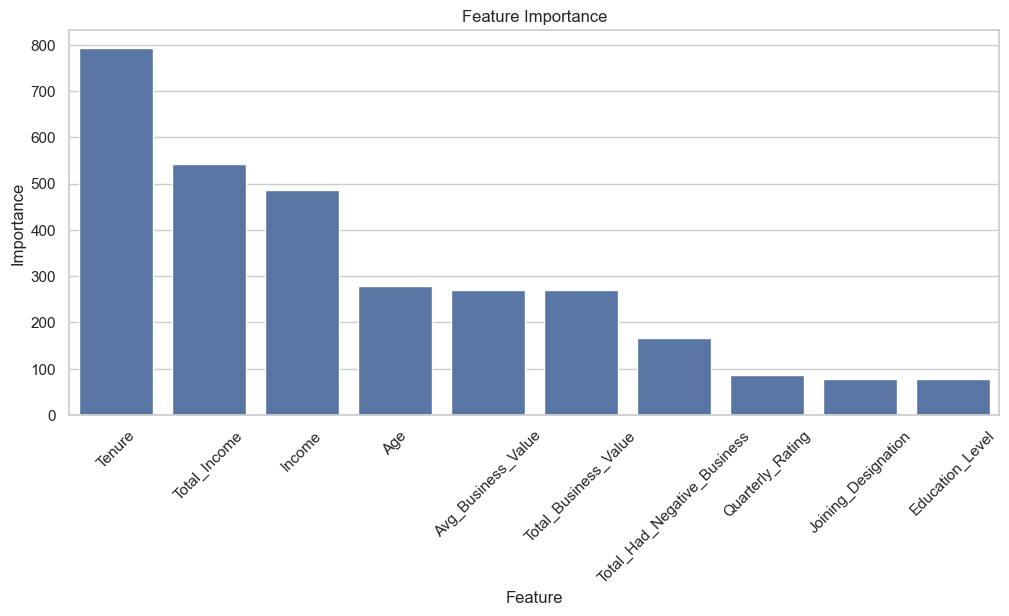

In [12]:


def plot_feature_importance(pipeline_model, X):
    feature_importances = pipeline_model.named_steps['classifier'].feature_importances_
    feature_names = pipeline_model.named_steps['preprocessor'].get_feature_names_out()
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 5))
    sns.barplot(data=feature_importance_df.head(10), y='Importance', x='Feature')
    plt.title('Feature Importance')
    plt.xticks(rotation=45)
    plt.show()
plot_feature_importance(pipeline_model, X)

In [13]:
joblib.dump(pipeline_model, "../models/final_pipeline_model_sklearn.pkl")

['../models/final_pipeline_model_sklearn.pkl']

In [14]:
test_df = df.sample(1)
test_df

,Driver_ID,Date_Of_Joining,Total_Business_Value,Total_Had_Negative_Business,Has_Income_Increased,Has_Rating_Increased,Avg_Business_Value,Last_Reporting_Month,Age,Gender,...,City,Joining_Designation,Grade,Quarterly_Rating,Last_Working_Date,Churned,Tenure,Date_Of_Joining_month,Date_Of_Joining_year,Is_Valuable_Driver
1488,1744,2018-08-31,0,0,0,0,0,2019-01-01,23,0,...,C22,1,1,1,2019-02-01,1,154,8,2018,0


In [16]:
_ ={
  'Total_Business_Value': 502040,
  'Total_Had_Negative_Business': 2,
  'Has_Income_Increased': 0,
  'Has_Rating_Increased': 1,
  'Avg_Business_Value': 71720,
  'Age': 36,
  'Gender': 0,
  'Income': 58626,
  'Total_Income': 410382,
  'Education_Level': 1,
  'City': 'C2',
  'Joining_Designation': 3,
  'Grade': 3,
  'Quarterly_Rating': 2,
  'Tenure': 390,
  'Is_Valuable_Driver': 1
  }

In [17]:
mdf=pd.DataFrame([_])

In [18]:
pred = pipeline_model.predict_proba(mdf)
pred[0]

[LightGBM] [Warning] bagging_fraction is set=0.7612915269858092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612915269858092


array([0.04157879, 0.95842121])

In [19]:
pred = pipeline_model.predict(mdf)
pred[0]

[LightGBM] [Warning] bagging_fraction is set=0.7612915269858092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612915269858092


1

In [23]:
X_transformed = preprocessor.fit_transform(X)
X_transformed = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())
loaded_processor = pipeline_model.named_steps["preprocessor"]
tmdf = loaded_processor.transform(mdf)
tmdf = pd.DataFrame(tmdf, columns=loaded_processor.get_feature_names_out())

In [24]:
tmdf

,City_C1,City_C10,City_C11,City_C12,City_C13,City_C14,City_C15,City_C16,City_C17,City_C18,...,Age,Gender,Income,Total_Income,Education_Level,Joining_Designation,Grade,Quarterly_Rating,Tenure,Is_Valuable_Driver
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,36.0,0.0,58626.0,410382.0,1.0,3.0,3.0,2.0,390.0,1.0


In [25]:
explainer = shap.TreeExplainer(pipeline_model.named_steps['classifier'], X_transformed)
shap.initjs()

In [26]:
# save the explainer
joblib.dump(explainer, "../models/final_explainer.pkl")

['../models/final_explainer.pkl']

In [27]:
shape_values = explainer(tmdf)

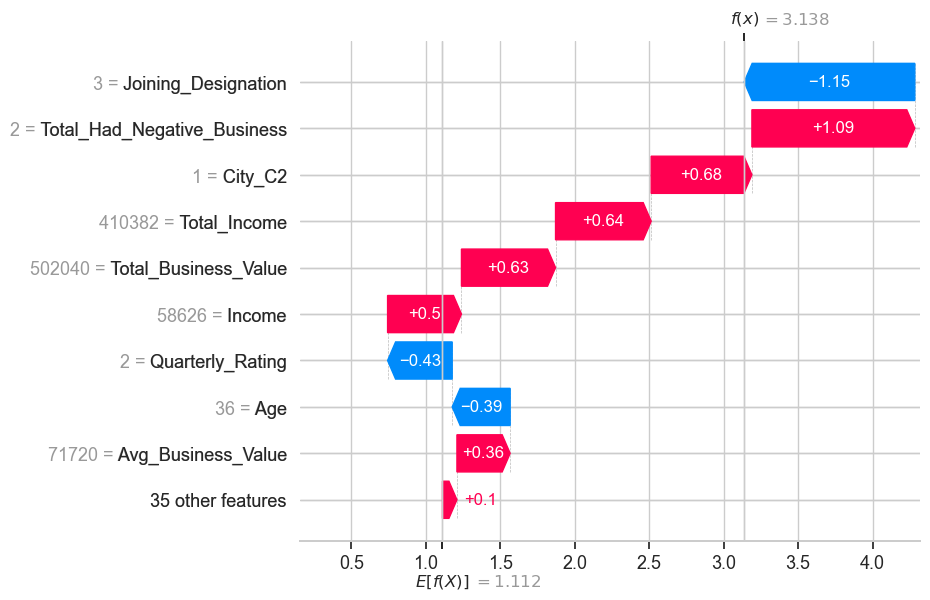

In [28]:
shap.plots.waterfall(shape_values[0], max_display=10)